In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score


In [2]:
data = pd.read_csv('../data/processed/aggregated_dataset.csv')
print("Cleaned dataset shape:", data.shape)
data.head()

Cleaned dataset shape: (40674, 1033)


,NLOS,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,...,CIR1013,CIR1014,CIR1015,CIR_MEAN,CIR_VAR,CIR_SKEW,CIR_ENERGY_FIRST_100,CIR_PEAK_BIN,RISE_TIME,RISE_TIME_CLIPPED
0,0.0,3.90,745.0,18712.0,10250.0,11576.0,64.0,11855.0,967.0,611.0,...,505.0,307.0,0.0,395.225394,1.503746e+06,10.561181,22550.0,748,3.0,3.0
1,0.0,0.66,749.0,11239.0,6313.0,4712.0,64.0,18968.0,1133.0,447.0,...,89.0,103.0,0.0,444.060039,2.665030e+06,8.523565,20796.0,757,8.0,8.0
2,1.0,7.86,746.0,4355.0,5240.0,3478.0,60.0,14699.0,894.0,723.0,...,96.0,218.0,0.0,503.485236,1.859169e+06,7.101177,21061.0,754,8.0,8.0
3,1.0,3.48,750.0,8502.0,8416.0,5890.0,76.0,8748.0,1127.0,1024.0,...,155.0,342.0,256.0,413.054134,1.097226e+06,9.486008,26896.0,756,6.0,6.0
4,0.0,1.19,746.0,17845.0,18095.0,12058.0,68.0,11380.0,1744.0,276.0,...,247.0,292.0,256.0,363.357283,1.438949e+06,11.789746,21277.0,750,4.0,4.0


In [6]:
print("Data types for each column:")
print(data.dtypes)

# Print number of elements
print(f"Total number of elements: {data.size}")

# Print range of each numeric column
print("\nRange for each numeric column:")
for column in data.select_dtypes(include=[np.number]).columns:
    print(f"{column} range: {data[column].min()} to {data[column].max()}")

Data types for each column:
NLOS                    float64
RANGE                   float64
FP_IDX                  float64
FP_AMP1                 float64
FP_AMP2                 float64
                         ...   
CIR1015                 float64
CIR_MEAN                float64
CIR_VAR                 float64
CIR_SKEW                float64
CIR_ENERGY_FIRST_100    float64
Length: 1030, dtype: object
Total number of elements: 41897310

Range for each numeric column:
NLOS range: 0.0 to 1.0
RANGE range: 0.0 to 28.02
FP_IDX range: 707.0 to 848.0
FP_AMP1 range: 7.0 to 20572.0
FP_AMP2 range: 63.0 to 20624.0
FP_AMP3 range: 187.0 to 20577.0
STDEV_NOISE range: 28.0 to 220.0
CIR_PWR range: 0.0 to 31709.0
MAX_NOISE range: 310.0 to 5169.0
RXPACC range: 128.0 to 1056.0
CIR0 range: 2.0 to 844.0
CIR1 range: 3.0 to 912.0
CIR2 range: 1.0 to 916.0
CIR3 range: 0.0 to 997.0
CIR4 range: 1.0 to 1256.0
CIR5 range: 1.0 to 1012.0
CIR6 range: 1.0 to 1057.0
CIR7 range: 0.0 to 1007.0
CIR8 range: 0.0 to 895.0

In [7]:
print(data['NLOS'].value_counts(normalize=True))

NLOS
0.0    0.507043
1.0    0.492957
Name: proportion, dtype: float64


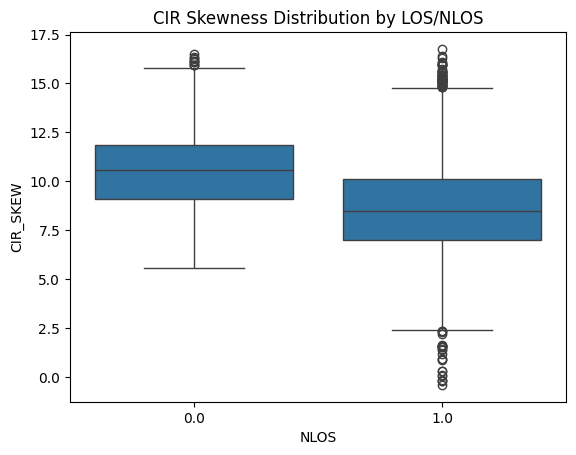

In [6]:
import seaborn as sns

# Example: CIR_SKEW vs. NLOS
sns.boxplot(x="NLOS", y="CIR_SKEW", data=data)
plt.title("CIR Skewness Distribution by LOS/NLOS")
plt.show()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\user\AppData\Local\Temp\ipykernel_30532\1333035497.py:1: SyntaxWarning: invalid escape sequence '\d'
  data['CIR_PEAK_BIN'] = data.loc[:, 'CIR0':'CIR1015'].idxmax(axis=1).str.extract('(\d+)').astype(int)


<Axes: xlabel='NLOS', ylabel='CIR_PEAK_BIN'>

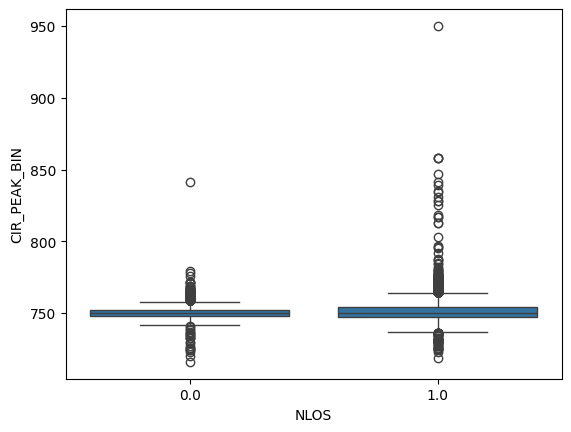

In [7]:
data['CIR_PEAK_BIN'] = data.loc[:, 'CIR0':'CIR1015'].idxmax(axis=1).str.extract('(\d+)').astype(int)
sns.boxplot(x='NLOS', y='CIR_PEAK_BIN', data=data)

In [8]:
# Calculate RISE_TIME
data['RISE_TIME'] = data['CIR_PEAK_BIN'] - data['FP_IDX']

# Filter invalid values
data = data[data['RISE_TIME'] >= 0]

# Clip outliers
rise_time_threshold = data['RISE_TIME'].quantile(0.99)
data['RISE_TIME_CLIPPED'] = data['RISE_TIME'].clip(upper=rise_time_threshold)

# Verify
data.to_csv('../data/processed/aggregated_dataset.csv', index=False)

In [9]:
print(data['RISE_TIME'].describe())

count    40674.000000
mean         5.194326
std          5.272344
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        191.000000
Name: RISE_TIME, dtype: float64


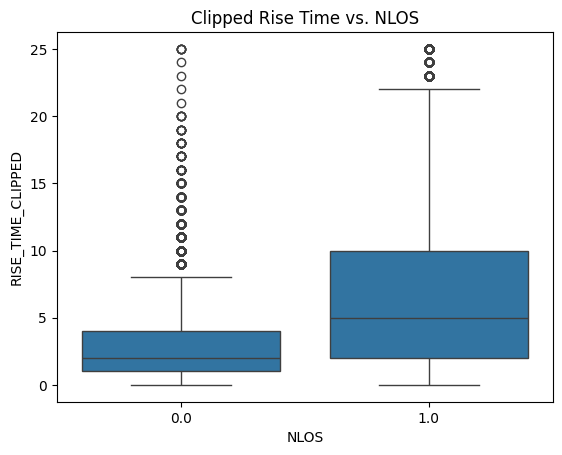

In [10]:
sns.boxplot(x="NLOS", y="RISE_TIME_CLIPPED", data=data)
plt.title("Clipped Rise Time vs. NLOS")
plt.show()

In [11]:
from scipy.stats import ttest_ind
los_skew = data[data['NLOS'] == 0]['CIR_SKEW']
nlos_skew = data[data['NLOS'] == 1]['CIR_SKEW']
t_stat, p_value = ttest_ind(los_skew, nlos_skew)
print(f"p-value: {p_value:.4f}")  # Expect p < 0.05

p-value: 0.0000


In [12]:
corr_matrix = data.corr()
nlos_corr = corr_matrix["NLOS"].sort_values(ascending=False)
print(nlos_corr.head(20))  # Top 20 positively correlated features
print(nlos_corr.tail(20))  # Top 20 negatively correlated features

NLOS                    1.000000
RXPACC                  0.729013
RANGE                   0.459487
CIR_ENERGY_FIRST_100    0.376756
RISE_TIME_CLIPPED       0.374514
RISE_TIME               0.364942
CIR742                  0.322071
CIR741                  0.318470
CIR574                  0.280460
CIR740                  0.268030
CIR326                  0.266341
CIR646                  0.261298
CIR582                  0.260082
CIR575                  0.257207
CIR246                  0.257149
CIR526                  0.256494
CIR654                  0.255777
CIR350                  0.255239
CIR590                  0.255220
CIR430                  0.254745
Name: NLOS, dtype: float64
CIR758      -0.086083
CIR757      -0.116700
CIR747      -0.124370
CIR756      -0.154613
CIR748      -0.177593
CIR755      -0.196550
CIR754      -0.237581
CIR749      -0.240962
CIR753      -0.280467
CIR750      -0.302476
MAX_NOISE   -0.309384
CIR752      -0.318375
FP_IDX      -0.326977
CIR751      -0.335038
CIR_P

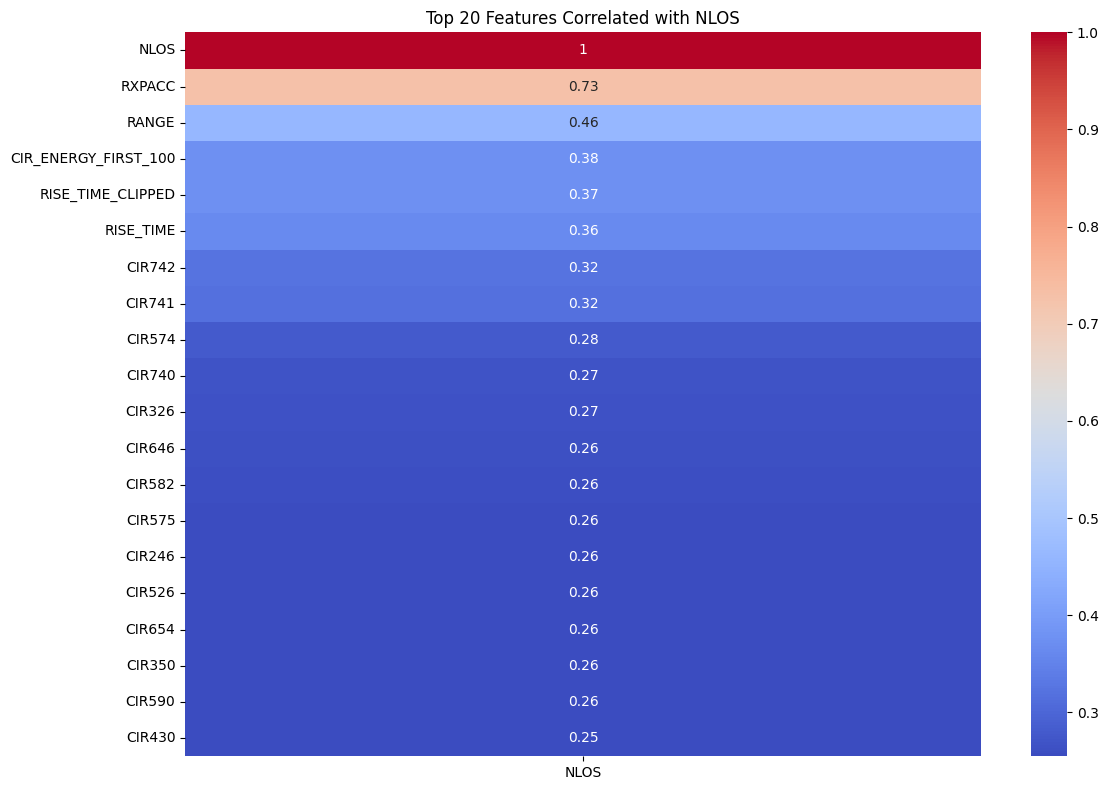

In [13]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[["NLOS"]].sort_values(by="NLOS", ascending=False).head(20), 
            annot=True, cmap='coolwarm')
plt.title('Top 20 Features Correlated with NLOS')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()